<a href="https://colab.research.google.com/github/othniel77/datascience/blob/main/Pr%C3%A9diction_du_Bitcoin_avec_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import files
data_to_load = files.upload()

Saving BTC.csv to BTC.csv


In [3]:
btc_data = pd.read_csv('/content/BTC.csv')
btc_data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.610496e+12,2021-01-13 00:00:00,BTC/USDT,34049.15,34049.15,33589.57,33606.99,655.275245,2.215246e+07,11838.0
1,1.610410e+12,2021-01-12 00:00:00,BTC/USDT,35410.37,36628.00,32531.00,34051.24,133948.151996,4.651302e+09,2674145.0
2,1.610323e+12,2021-01-11 00:00:00,BTC/USDT,38150.02,38264.74,30420.00,35404.47,249131.539943,8.426880e+09,4431451.0
3,1.610237e+12,2021-01-10 00:00:00,BTC/USDT,40088.22,41350.00,35111.11,38150.02,118209.544503,4.604035e+09,2628050.0
4,1.610150e+12,2021-01-09 00:00:00,BTC/USDT,40586.96,41380.00,38720.00,40088.22,75785.979675,3.054779e+09,1998156.0


In [5]:
btc_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unix         1247 non-null   float64
 1   date         1247 non-null   object 
 2   symbol       1247 non-null   object 
 3   open         1247 non-null   float64
 4   high         1247 non-null   float64
 5   low          1247 non-null   float64
 6   close        1247 non-null   float64
 7   Volume BTC   1247 non-null   float64
 8   Volume USDT  1247 non-null   float64
 9   tradecount   1123 non-null   float64
dtypes: float64(8), object(2)
memory usage: 97.5+ KB


In [6]:
# Handle missing values in 'tradecount' column
btc_data['tradecount'].fillna(btc_data['tradecount'].mean(), inplace=True)
btc_data.isnull().sum()


unix           0
date           0
symbol         0
open           0
high           0
low            0
close          0
Volume BTC     0
Volume USDT    0
tradecount     0
dtype: int64

In [7]:
# convert date format
btc_data['date'] = pd.to_datetime(btc_data['date'], format="%Y-%m-%d",errors='coerce')

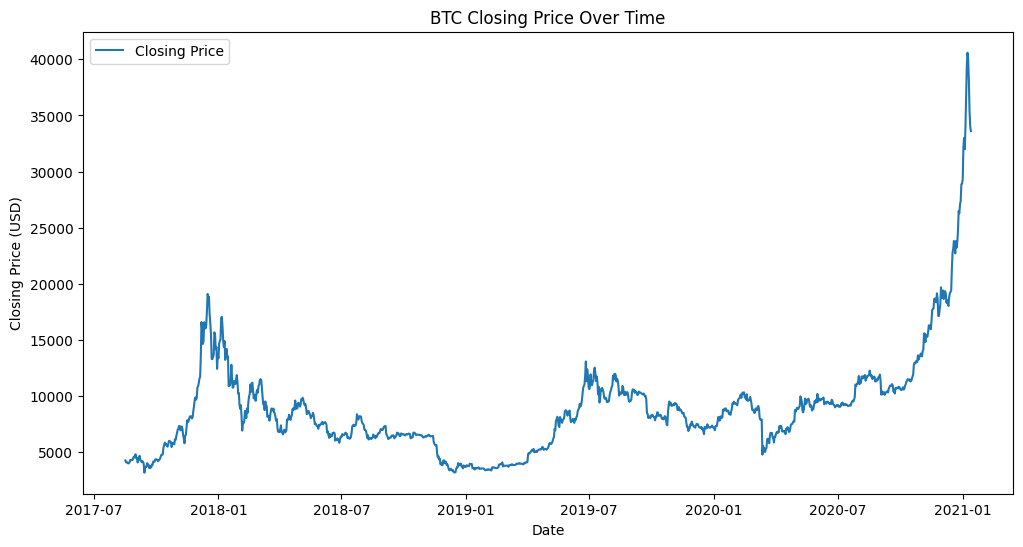

In [8]:
# Visualize data
# Time series plot
plt.figure(figsize=(12, 6))
plt.plot(btc_data['date'], btc_data['close'], label='Closing Price')
plt.title('BTC Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

In [9]:
# Select only numeric columns for correlation matrix
num_col = btc_data.select_dtypes(include=['float64']).columns
corr = btc_data[num_col].corr()

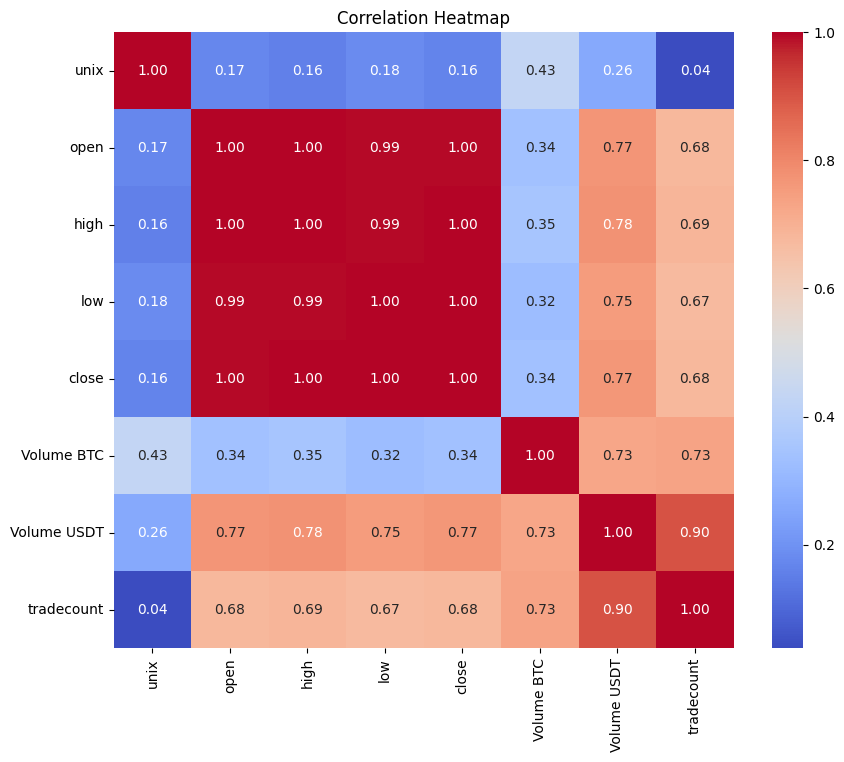

In [10]:
# Plot the correlation heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


standardisons : centrer et réduire

In [12]:
# Feature scaling using Min-Max scaling
scaler = MinMaxScaler()
fs = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT', 'tradecount']
# Apply Min-Max scaling to selected features
btc_data[fs] = scaler.fit_transform(btc_data[fs])

In [13]:
# Feature engineering
window_size = 10
btc_data['SMA'] = btc_data['close'].rolling(window=window_size).mean()
# Display the preprocessed data
print("Preprocessed Data:")
print(btc_data.head())


Preprocessed Data:
           unix       date    symbol      open      high       low     close  \
0  1.610496e+12 2021-01-13  BTC/USDT  0.825183  0.795704  0.857103  0.813450   
1  1.610410e+12 2021-01-12  BTC/USDT  0.861581  0.862386  0.827619  0.825330   
2  1.610323e+12 2021-01-11  BTC/USDT  0.934838  0.904708  0.768822  0.861519   
3  1.610237e+12 2021-01-10  BTC/USDT  0.986664  0.984486  0.899482  0.934941   
4  1.610150e+12 2021-01-09  BTC/USDT  1.000000  0.985261  1.000000  0.986773   

   Volume BTC  Volume USDT  tradecount  SMA  
0    0.001069     0.002514    0.000000  NaN  
1    0.332663     0.551909    0.602385  NaN  
2    0.619206     1.000000    1.000000  NaN  
3    0.293510     0.546299    0.591955  NaN  
4    0.187972     0.362431    0.449433  NaN  


Définissons les paramètres de Q-learning

In [14]:
gamma = 0.9 # Discount factor
alpha = 0.1 # Learning rate
epsilon = 0.1 # Exploration-exploitation trade-off


Définissons l'algorithme de Q-learning

In [15]:
def q_learning(Q, state, action, reward, next_state):
    current_value = Q[state, action]
    max_future_value = np.max(Q[next_state, :])
    new_value = (1 - alpha) * current_value + alpha * (reward + gamma *max_future_value)
    Q[state, action] = new_value
    return Q


In [16]:
train_data, test_data = train_test_split(btc_data, test_size=0.2,random_state=42)


In [17]:
# Initialize Q-table
num_states = 100
num_actions = 2
Q = np.zeros((num_states, num_actions))


Entrainons le modèle Q-learning

In [18]:
for index, row in train_data.iterrows():
    state = int(index % num_states)
    action = 1 if row['close'] < row['SMA'] else 0 # Buy if the price is belowthe moving average, else sell
    reward = row['close'] - row['SMA'] # Reward is the difference from the moving average
    next_state = int((index + 1) % num_states) # Simple next state representation, adjust accordingly
    Q = q_learning(Q, state, action, reward, next_state)


évaluons le modèle Q-learning

In [19]:
# Testing the Q-learning model
total_reward = 0
actions_taken = []
for index, row in test_data.iterrows():
    state = int(index % num_states)
    action = np.argmax(Q[state, :])
    actions_taken.append(action)
    reward = row['close'] - row['SMA']
    total_reward += reward

Visualisons les actions entreprises durant l'évaluation (Testing)

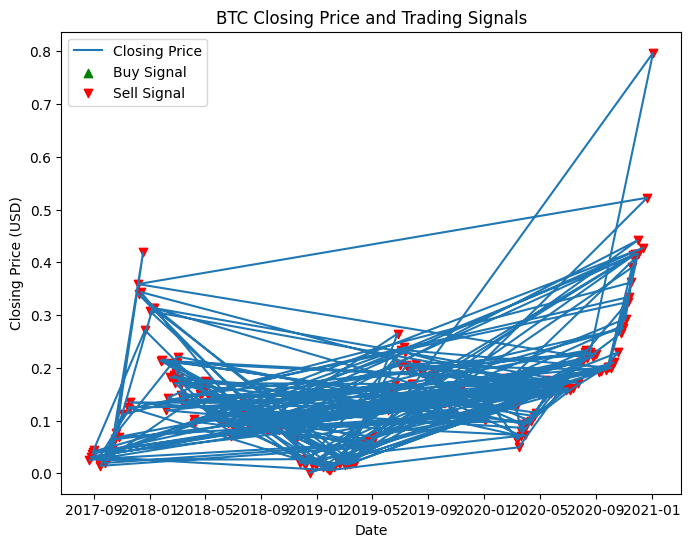

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(test_data['date'], test_data['close'], label='Closing Price')
# Filter buy signals
buy_signals = test_data['date'][np.array(actions_taken) == 1]
plt.scatter(buy_signals, test_data.loc[test_data['date'].isin(buy_signals)]['close'],
color='green', label='Buy Signal', marker='^')
# Filter sell signals
sell_signals = test_data['date'][np.array(actions_taken) == 0]
plt.scatter(sell_signals, test_data.loc[test_data['date'].isin(sell_signals)]['close'],
color='red', label='Sell Signal', marker='v')
plt.title('BTC Closing Price and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()



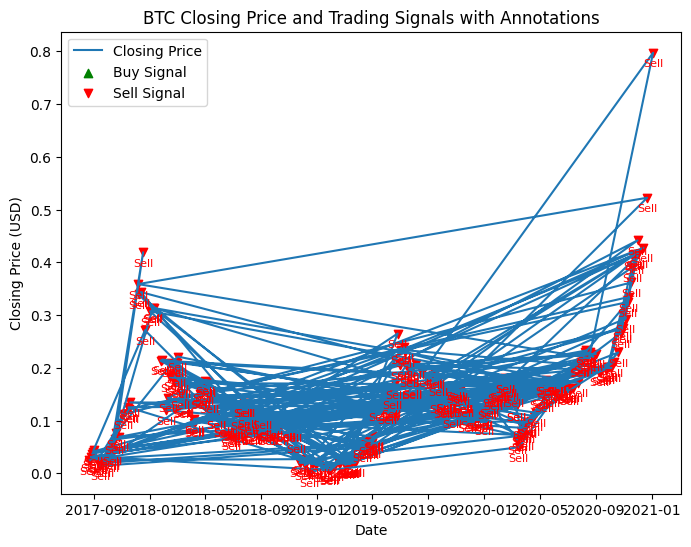

In [21]:
# Visualize actions taken during testing with annotations
plt.figure(figsize=(8, 6))
plt.plot(test_data['date'], test_data['close'], label='Closing Price')
# Filter buy signals
buy_signals = test_data['date'][np.array(actions_taken) == 1]
plt.scatter(buy_signals, test_data['close'].loc[test_data['date'].isin(buy_signals)],
color='green', label='Buy Signal', marker='^')

# Filter sell signals
sell_signals = test_data['date'][np.array(actions_taken) == 0]
plt.scatter(sell_signals, test_data['close'].loc[test_data['date'].isin(sell_signals)],
color='red', label='Sell Signal', marker='v')

# Annotate Buy signals
for date, price in zip(buy_signals, test_data['close'].loc[test_data['date'].isin(buy_signals)]):
    plt.annotate('Buy', (date, price), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='green')
# Annotate Sell signals
for date, price in zip(sell_signals, test_data['close'].loc[test_data['date'].isin(sell_signals)]):
    plt.annotate('Sell', (date, price), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=8, color='red')
plt.title('BTC Closing Price and Trading Signals with Annotations')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()
